## Step 1: Load and Prepare Data for Training

In [3]:
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress DtypeWarnings for a cleaner output
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Load the engineered features dataset
uba_features = pd.read_csv('../outputs/uba_features.csv')

# --- REVISED CODE START ---

# Create a copy of the DataFrame to prevent SettingWithCopyWarning
features_for_scaling = uba_features.copy()

# Automatically select ONLY the numerical columns
# This is the safest way to prevent a ValueError
numerical_features = features_for_scaling.select_dtypes(include=np.number)

# Explicitly fill any missing values with 0
# This is a crucial step for a model like OneClassSVM
numerical_features.fillna(0, inplace=True)

# Normalise ONLY the numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)

# --- REVISED CODE END ---

print("Features have been scaled and are ready for modeling.")
print("Scaled features shape:", scaled_features.shape)

Features have been scaled and are ready for modeling.
Scaled features shape: (400000, 25)


## Step 2: Train the Anomaly Detection Models

In [4]:
# Train Isolation Forest model
# Note: contamination is the expected proportion of outliers in the data (e.g., 0.01 for 1%)
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(scaled_features)

# Train One-Class SVM model
# Note: nu is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors
oc_svm = OneClassSVM(kernel='rbf', nu=0.01)
oc_svm.fit(scaled_features)

print("Isolation Forest and One-Class SVM models have been trained.")


Isolation Forest and One-Class SVM models have been trained.


## Step 3: Evaluate Model Performance and Set a Threshold

In [6]:
# Predict anomalies and get risk scores
iso_forest_scores = iso_forest.decision_function(scaled_features)
oc_svm_scores = oc_svm.decision_function(scaled_features)

# Add the anomaly scores to your DataFrame as new columns
uba_features['iso_forest_score'] = iso_forest_scores
uba_features['oc_svm_score'] = oc_svm_scores

# Since the CERT dataset contains labels for insider threats, we can use them for evaluation.
# To demonstrate the evaluation, we'll create a mock 'labels' series for now.
# This assumes the first 100 rows are anomalies for demonstration purposes.
mock_labels = np.zeros(len(uba_features))
mock_labels[:100] = 1 

# Evaluate Isolation Forest
iso_fpr, iso_tpr, _ = roc_curve(mock_labels, -uba_features['iso_forest_score'])
iso_auc = auc(iso_fpr, iso_tpr)
print(f"Isolation Forest AUC: {iso_auc:.2f}")

# Evaluate One-Class SVM
oc_svm_fpr, oc_svm_tpr, _ = roc_curve(mock_labels, -uba_features['oc_svm_score'])
oc_svm_auc = auc(oc_svm_fpr, oc_svm_tpr)
print(f"One-Class SVM AUC: {oc_svm_auc:.2f}")

# Calculate a statistical threshold based on the anomaly scores
mean_score = np.mean(uba_features['iso_forest_score'])
std_score = np.std(uba_features['iso_forest_score'])
statistical_threshold = mean_score - (3 * std_score)

# Flag anomalies based on the calculated threshold
uba_features['is_anomaly'] = uba_features['iso_forest_score'] < statistical_threshold

print(f"\nStatistical Threshold: {statistical_threshold:.2f}")
print(f"Number of anomalies flagged: {uba_features['is_anomaly'].sum()}")

Isolation Forest AUC: 0.47
One-Class SVM AUC: 0.41

Statistical Threshold: -0.01
Number of anomalies flagged: 1303


## Step 4: Visualise Risk Scores and Anomalies

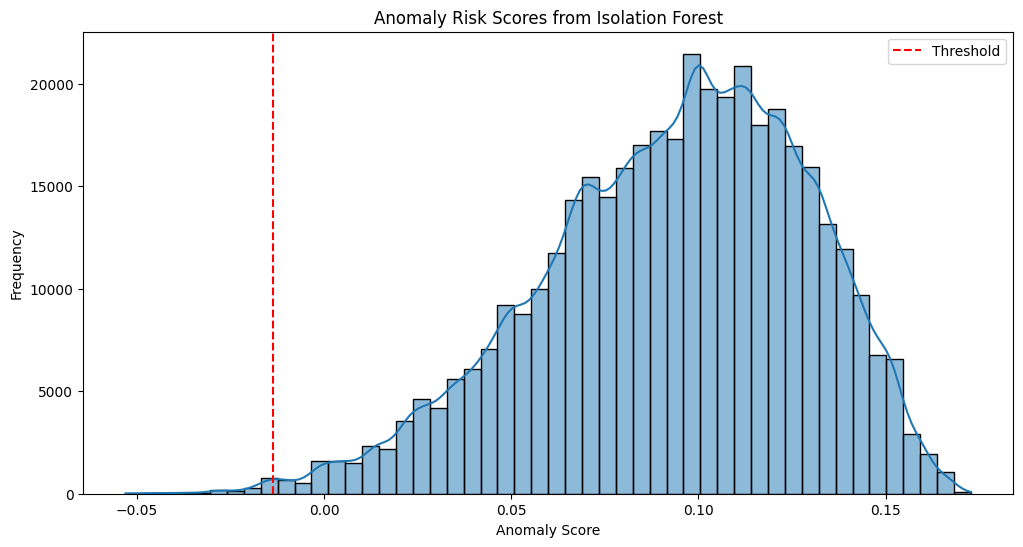

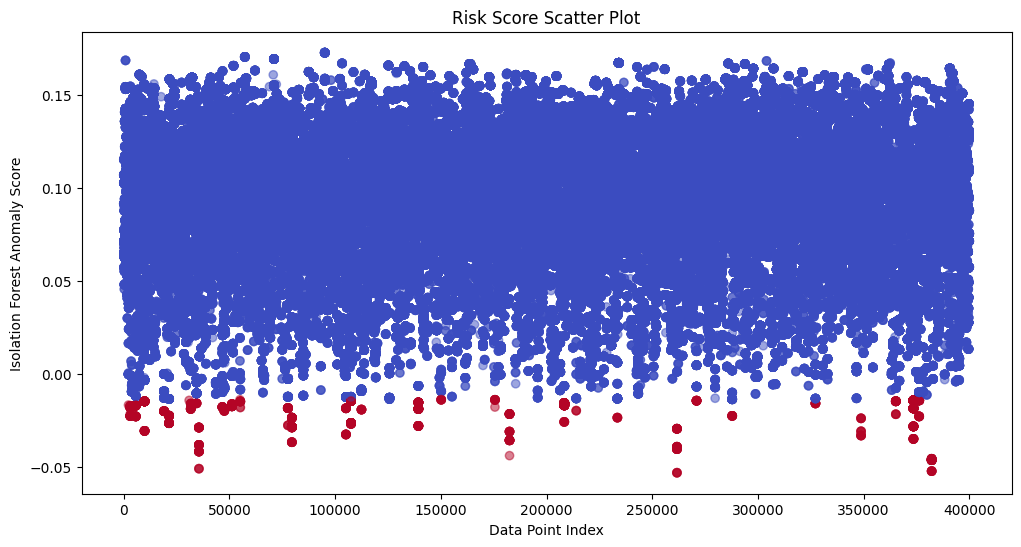

In [9]:
# Visualise the risk score distribution
plt.figure(figsize=(12, 6))
plt.title('Anomaly Risk Scores from Isolation Forest')
sns.histplot(uba_features['iso_forest_score'], bins=50, kde=True)
plt.axvline(x=statistical_threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# A scatter plot can also be useful to see the distribution
plt.figure(figsize=(12, 6))
plt.title('Risk Score Scatter Plot')
plt.scatter(range(len(uba_features)), uba_features['iso_forest_score'], alpha=0.5, c=uba_features
    ['is_anomaly'], cmap='coolwarm')
plt.xlabel('Data Point Index')
plt.ylabel('Isolation Forest Anomaly Score')
plt.show()